<a href="https://colab.research.google.com/github/FullFran/3D-tiktak-toe/blob/master/colab/3_model1_RGB_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importamos las librerías que vamos a utilizar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from google.colab import drive
drive.mount('/content/drive')

# '/content/drive/MyDrive/datos.csv'


Mounted at /content/drive


In [ ]:
%ls

drive/  model3-RGB.h5  sample_data/


In [5]:
# Cargamos los datos que vamos a utilizar.
df_train = pd.read_csv('/content/drive/MyDrive/prueba final/train-processed.csv')
df_val = pd.read_csv('/content/drive/MyDrive/prueba final/val-processed.csv')

images_train = np.load(
    '/content/drive/MyDrive/prueba final/image_array100_train.npy', allow_pickle=True)
images_val = np.load(
    '/content/drive/MyDrive/prueba final/image_array100_val.npy', allow_pickle=True)


In [6]:
print(images_train.shape)
print(images_val.shape)

(6637, 100, 100, 3)
(6685, 100, 100, 3)


In [7]:
X = images_train
y_gender = df_train['Gender']
y_age_raw = df_train['Age']
# Normalizamos los datos de edad para obtener mejor convergencia
# 80 es el mayor dato de edad según el autor del set de datos.
y_age = y_age_raw / 80 

y_gender = np.array(y_gender)
y_age = np.array(y_age)

print('Dimensiones de X:', X.shape)
print('Dimensiones de y_gender:', y_gender.shape)
print('Dimensiones de y_age:', y_age.shape)

Dimensiones de X: (6637, 100, 100, 3)
Dimensiones de y_gender: (6637,)
Dimensiones de y_age: (6637,)


In [8]:
X_val = images_val
y_gender_val = df_val['Gender']
y_age_raw_val = df_val['Age']
y_age_val = y_age_raw_val / 80

y_gender_val = np.array(y_gender_val)
y_age_val = np.array(y_age_val)

print('Dimensiones de X:', X_val.shape)
print('Dimensiones de y_gender:', y_gender_val.shape)
print('Dimensiones de y_age:', y_age_val.shape)

Dimensiones de X: (6685, 100, 100, 3)
Dimensiones de y_gender: (6685,)
Dimensiones de y_age: (6685,)


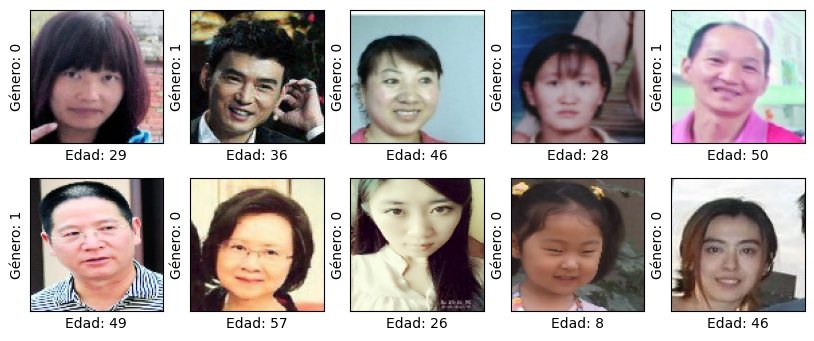

In [9]:
# Verificamos que todo esté correcto:
plt.figure(figsize=(10, 4))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i])
    plt.xlabel(f'Edad: {int(80*y_age[i])}')
    plt.ylabel(f'Género: {y_gender[i]}')
plt.show()


In [10]:
# Creamos nuestro modelo:
# Definición de la entrada
inputs = Input(shape=(100, 100, 3), name='input_1')

# Capas de convolución
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_1')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_1')(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu', name='conv2d_2')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_2')(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu', name='conv2d_3')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_3')(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv2d_4')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_4')(conv_4)

# Capa de aplanamiento
flatten = Flatten()(maxp_4)

# Capas totalmente conectadas
dense_1 = Dense(256, activation='relu', name='dense_1')(flatten)
dense_2 = Dense(256, activation='relu', name='dense_2')(flatten)

# Capas de dropout
dropout_1 = Dropout(0.3, name='dropout_1')(dense_1)
dropout_2 = Dropout(0.3, name='dropout_2')(dense_2)

# Capas de salida
output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

# Creación del modelo
model = Model(inputs=inputs, outputs=[output_1, output_2])

# Resumen del modelo
model.summary()

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam', metrics=['accuracy', 'mae'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 98, 98, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 49, 49, 32)  0           ['conv2d_1[0][0]']               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 47, 47, 64)   18496       ['max_pooling2d_1[0][0]']    

In [11]:
ckpt_path = 'model1-RGB.h5'
# Crear el callback para guardar los pesos
checkpoint_callback = ModelCheckpoint(
    filepath=ckpt_path,
    save_weights_only=False,
    monitor='val_loss',  # Monitorear la pérdida en el conjunto de validación
    save_best_only=True,  # Guardar solo los pesos del mejor modelo según la métrica monitoreada
    mode='min',  # Modo 'min' para minimizar la pérdida
    verbose=1)  # Imprimir mensajes al guardar los pesos

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenamos al modelo:
history = model.fit(x=X, y={'gender_out': y_gender, 'age_out': y_age}, batch_size=32, 
                    epochs=20, validation_data=(X_val, {'gender_out': y_gender_val, 'age_out': y_age_val}),callbacks=[early_stopping, checkpoint_callback] )

Epoch 1/20
208/208 [==============================] - ETA: 0s - loss: 0.8198 - gender_out_loss: 0.6358 - age_out_loss: 0.1840 - gender_out_accuracy: 0.6303 - gender_out_mae: 0.4491 - age_out_accuracy: 7.5335e-04 - age_out_mae: 0.1840
Epoch 1: val_loss improved from inf to 0.70435, saving model to model1-RGB.h5
208/208 [==============================] - 21s 34ms/step - loss: 0.8198 - gender_out_loss: 0.6358 - age_out_loss: 0.1840 - gender_out_accuracy: 0.6303 - gender_out_mae: 0.4491 - age_out_accuracy: 7.5335e-04 - age_out_mae: 0.1840 - val_loss: 0.7043 - val_gender_out_loss: 0.5375 - val_age_out_loss: 0.1668 - val_gender_out_accuracy: 0.7260 - val_gender_out_mae: 0.3726 - val_age_out_accuracy: 2.9918e-04 - val_age_out_mae: 0.1668
Epoch 2/20
206/208 [============================>.] - ETA: 0s - loss: 0.6753 - gender_out_loss: 0.5066 - age_out_loss: 0.1687 - gender_out_accuracy: 0.7511 - gender_out_mae: 0.3402 - age_out_accuracy: 0.0015 - age_out_mae: 0.1687
Epoch 2: val_loss improved fr

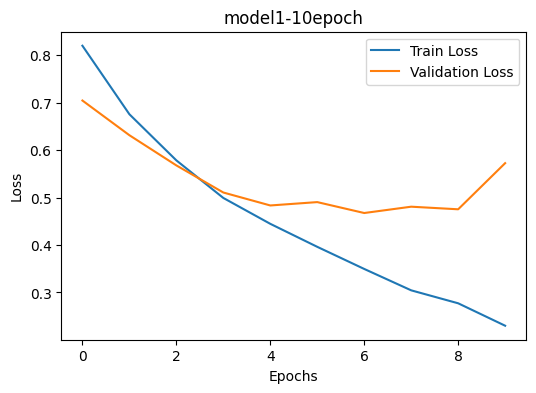

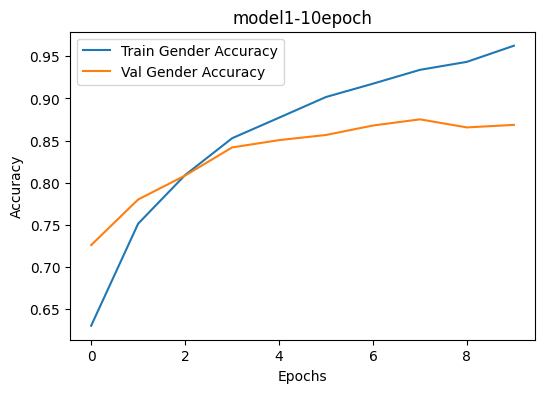

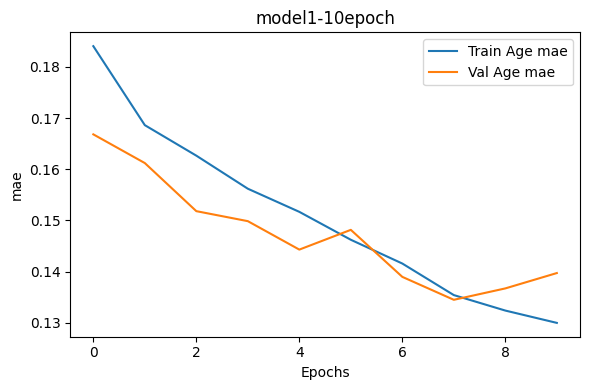

In [12]:
# Obtener las métricas del historial
train_loss = history.history['loss']
train_gender_loss = history.history['gender_out_loss']
train_age_loss = history.history['age_out_loss']
train_gender_accuracy = history.history['gender_out_accuracy']
train_age_mae = history.history['age_out_mae']

val_loss = history.history['val_loss']
val_gender_loss = history.history['val_gender_out_loss']
val_age_loss = history.history['val_age_out_loss']
val_gender_accuracy = history.history['val_gender_out_accuracy']
val_age_mae = history.history['val_age_out_mae']

titulo = 'model1-10epoch'

# Graficar las curvas de pérdida
plt.figure(figsize=(6, 4))
plt.title(titulo)

plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Graficar las curvas de precisión
plt.figure(figsize=(6, 4))
plt.title(titulo)
plt.plot(train_gender_accuracy, label='Train Gender Accuracy')
plt.plot(val_gender_accuracy, label='Val Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Graficar las curvas de error:
plt.figure(figsize=(6, 4))
plt.title(titulo)
plt.plot(train_age_mae, label='Train Age mae')
plt.plot(val_age_mae, label='Val Age mae')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
pred = model.predict(X_val)

y_age_pred = np.round(80*pred[1],2)
y_gender_pred = np.round(pred[0],2)

209/209 [==============================] - 1s 6ms/step


In [14]:
model.evaluate(X_val, [y_gender_val, y_age_val])

209/209 [==============================] - 2s 7ms/step - loss: 0.4673 - gender_out_loss: 0.3283 - age_out_loss: 0.1390 - gender_out_accuracy: 0.8679 - gender_out_mae: 0.1717 - age_out_accuracy: 0.0033 - age_out_mae: 0.1390


[0.46731483936309814,
 0.32833224534988403,
 0.13898253440856934,
 0.8679132461547852,
 0.17166949808597565,
 0.0032909498549997807,
 0.13898253440856934]

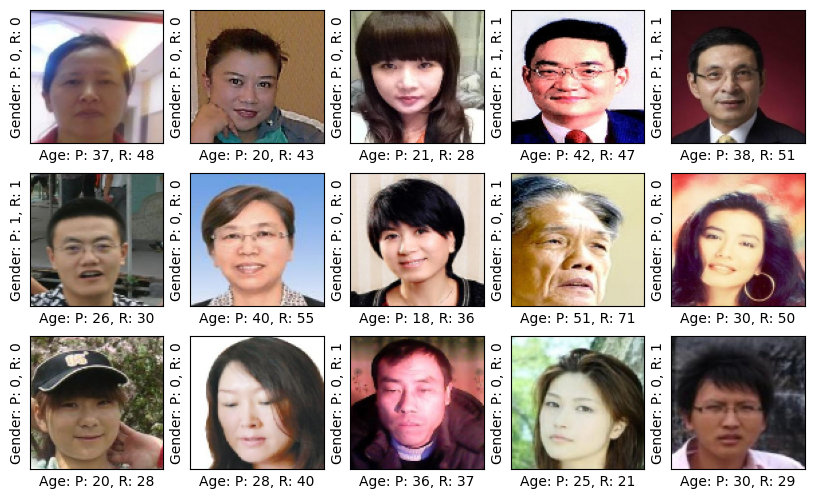

In [15]:
# Verificamos que todo esté correcto:
plt.figure(figsize=(10, 6))

paso = np.random.randint(0,6685-16)
paso = 0
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_val[i+paso])
    plt.xlabel(f'Age: P: {int(y_age_pred[i+paso])}, R: {y_age_raw_val[i+paso]}')
    plt.ylabel(f'Gender: P: {int(y_gender_pred[i+paso])}, R: {y_gender_val[i+paso]}')
plt.show()

In [16]:
error_edad=np.zeros(len(range(2,81)))
count_edad = np.zeros(len(range(2,81)))
x_error_edad = np.array(range(2,81))

for y_edad, predicho in zip(y_age_raw_val, y_age_pred):
    for i_edad, edad in enumerate(x_error_edad):
        if edad == y_edad:
            
            count_edad[i_edad]+=1 
            error_edad[i_edad] += abs(y_edad-float(predicho))
            

error_edad = error_edad / count_edad
 

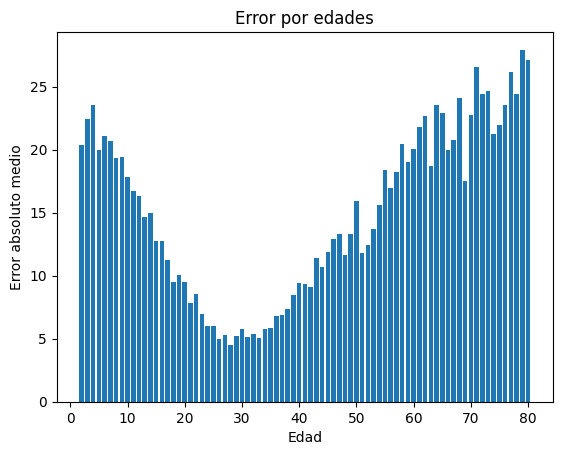

In [18]:
plt.bar(x_error_edad, error_edad)
plt.title('Error por edades')
plt.ylabel('Error absoluto medio')
plt.xlabel('Edad')
plt.show()